## Timeseries anomaly detection using an Autoencoder (Keras)

* Source : https://keras.io/examples/timeseries/timeseries_anomaly_detection/  

> 참고 : Tensorflow vs Keras vs Pytorch (https://hongong.hanbit.co.kr/%EB%94%A5%EB%9F%AC%EB%8B%9D-%ED%94%84%EB%A0%88%EC%9E%84%EC%9B%8C%ED%81%AC-%EB%B9%84%EA%B5%90-%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C-%EC%BC%80%EB%9D%BC%EC%8A%A4-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98/)

------

### Setup

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

### Load the data
We will use the Numenta Anomaly Benchmark(NAB) dataset. **It provides artifical timeseries data containing labeled anomalous periods of behavior.** Data are ordered, timestamped, single-valued metrics.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# train data
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# test data
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

### Quick Look at the Data

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
(4032, 1)


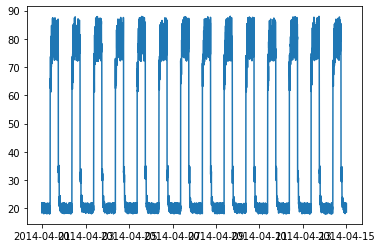

In [3]:
print(df_small_noise.head())
print(df_small_noise.shape)
plt.plot(df_small_noise)

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739
(4032, 1)


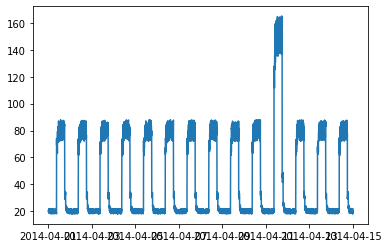

In [4]:
print(df_daily_jumpsup.head())
print(df_daily_jumpsup.shape)
plt.plot(df_daily_jumpsup)

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the data is detected as an anomaly.



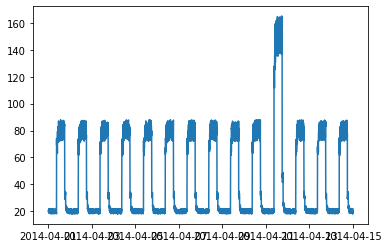

In [5]:
plt.plot(df_daily_jumpsup)

-----

### Prepare training data
Get data values from the training timeseries data file and normalize the value data. **We have a value for every 5 mins for 14 days.** (전체 timeseries data를 5분 간격으로 쪼개어 구간을 나누고 해당 구간에서의 value를 기록한 데이터임)

* 24*60/5 = 288 timesteps per day
* 288 * 14 = 4032 data points in total

In [6]:
time_steps = 24*60/5 # 이게 sequence임 (Time_period)
total_day = 14
if len(df_small_noise) == time_steps * total_day:
    print(f"Number of Traning Data is {len(df_small_noise)}")

Number of Traning Data is 4032


In [7]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise-training_mean)/training_std

### Create Sequences
Create sequences combining TIME_STEPS contiguous data values from the training data.

In [8]:
# Generated training sequences for use in the model
TIME_STEPS = 288
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values)-time_steps+1):
        output.append(values[i : (i+time_steps)])
    return np.stack(output)
    
x_train = create_sequences(df_training_value.values)

print("Traing input shape: ", x_train.shape)

Traing input shape:  (3745, 288, 1)


### Build a Model
We will build a convolutional reconstruction autoencoder model.

The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. 

In this case, sequence_length is 288 and num_features is 1.

In [9]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

### Train the Model

Please note that **we are using x_train as both the input and the target** since this is a *reconstruction model*.

In [10]:
history = model.fit(
    x_train,
    x_train, #x_train as a target as well as input
    epochs=15,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/15
27/27 [==============================] - 4s 109ms/step - loss: 0.6826 - val_loss: 0.1422
Epoch 2/15
27/27 [==============================] - 2s 67ms/step - loss: 0.1103 - val_loss: 0.0418
Epoch 3/15
27/27 [==============================] - 2s 66ms/step - loss: 0.0617 - val_loss: 0.0352
Epoch 4/15
27/27 [==============================] - 2s 66ms/step - loss: 0.0521 - val_loss: 0.0303
Epoch 5/15
27/27 [==============================] - 2s 70ms/step - loss: 0.0445 - val_loss: 0.0271
Epoch 6/15
27/27 [==============================] - 2s 70ms/step - loss: 0.0397 - val_loss: 0.0256
Epoch 7/15
27/27 [==============================] - 2s 68ms/step - loss: 0.0360 - val_loss: 0.0242
Epoch 8/15
27/27 [==============================] - 2s 73ms/step - loss: 0.0329 - val_loss: 0.0241
Epoch 9/15
27/27 [==============================] - 2s 70ms/step - loss: 0.0305 - val_loss: 0.0242
Epoch 10/15
27/27 [==============================] - 2s 72ms/step - loss: 0.0288 - val_loss: 0.0237
Epoch 11

Let's plot training and validation loss to see how the training went.

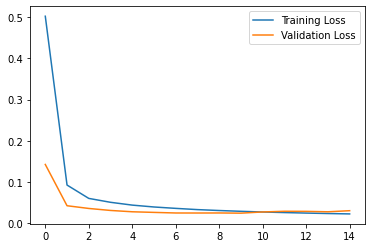

In [14]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

----
### Detecting Anonalies

We will detect anomalies by determining **how well our model can reconstruct the input data.**

* Find MAE loss on training samples.  

* **Find max MAE loss value.** *This is the worst our model has performed* trying to reconstruct a sample. We will make this the threshold for anomaly detection.  

[Leveraging the Threshold as a anlomaly detection standard]  
If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a **pattern that it isn't familiar with.** **We will label this sample as an anomaly.**

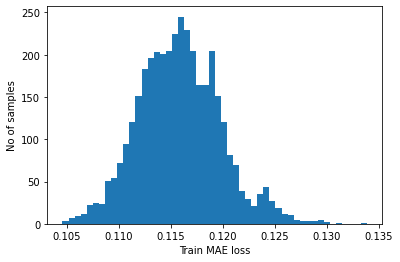

Reconstruction error threshold:  0.13384612892812303


In [15]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# check the distribution of mae_loss
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare Reconstruction

Let's see how our model has recontructed the first sample. This is the 288 timesteps from day 1 of our training dataset.

Text(0.5, 0, 'timestep(288)')

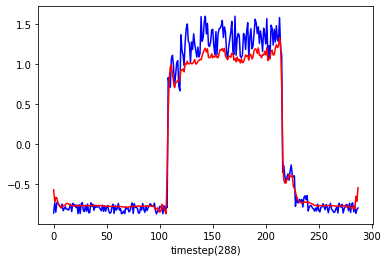

In [30]:
# Checking how the first sequence is learnt
plt.plot(x_train[0], "b")
plt.plot(x_train_pred[0], "r")
plt.xlabel("timestep(288)")

### Prepare Test Data
all setting are done. let's feed the test data

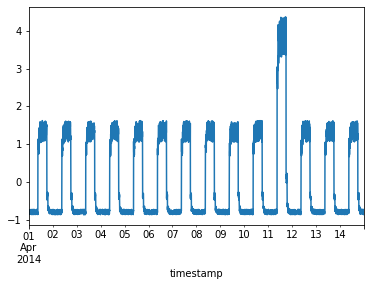

Test input shape:  (3745, 288, 1)


In [32]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values) 
print("Test input shape: ", x_test.shape)

In [50]:
# np.reshape() ; 원소 갯수에 맞게 크기 변환
a = np.array([[1,1,0], 
              [2,1,1]])
a.reshape(3,2)

a.reshape(-1) # 1차원 배열로 반환 (축이 1개, 한줄로 쭉 늘어놓기)

array([1, 1, 0, 2, 1, 1])

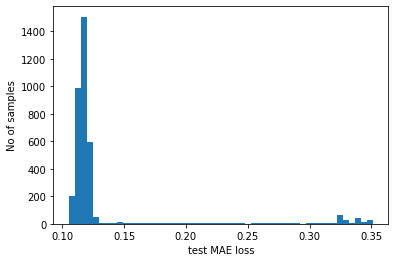

In [51]:
# Get test MAE loss of x_test.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50) #bins ; x축 구간 개수
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [52]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold 
# Threshold MAE 보다 에러가 높으면 다 이상치야 ! 

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  391
Indices of anomaly samples:  (array([2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
       2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2

### Plot Anomalies

We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data. We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

* 0, 1, 2
* 1, 2, 3
* 2, 3, 4
* 3, 4, 5
* 4, 5, 6
* 5, 6, 7
* 6, 7, 8
* 7, 8, 9

In [ ]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)